In [11]:
import numpy as np
from numpy.linalg import inv
import scipy as sci
import control
from scipy.signal import place_poles, StateSpace, lsim
import matplotlib.pyplot as plt
from sim import *
pi = np.pi


In [12]:
## Define SS

RE = 6378 # km
ROrb = 300 # km
r0 = RE + ROrb
mu = 398600


A = np.array([[           0, 1, 0,                0],
                [3*mu/(r0**3), 0, 0, 2*np.sqrt(mu/r0)],
                [ 0, 0, 0, 1],
                [0, -2*np.sqrt(mu/r0**5), 0, 0 ]])

B = np.array([[0,0],
                [1,0],
                [0,0],
                [0,1/r0]])

C = np.array([[1,0,0,0],[0,0,1,0]])

D = np.zeros([2,2])




In [13]:
## Define Reference Input and Constant Disturbance force

# Period of orbit
T = 2*pi*np.sqrt(r0**3/mu)

# Define simulation time to be 3 orbital periods
tvec = np.linspace(0,3*T,round(30*T))

omega_des = np.sqrt(mu/(r0**3))


# Define reference input
ref = np.vstack((np.zeros(len(tvec)), omega_des * tvec))
#ref = np.zeros(len(tvec))

# Define a disturbance profile
d = np.zeros([2,len(tvec)])

# For now, random constant disturbance
d[1,:] = -0.0001


G = np.array([[0,0],[1,0],[0,0],[0,1]])



System is reachable 



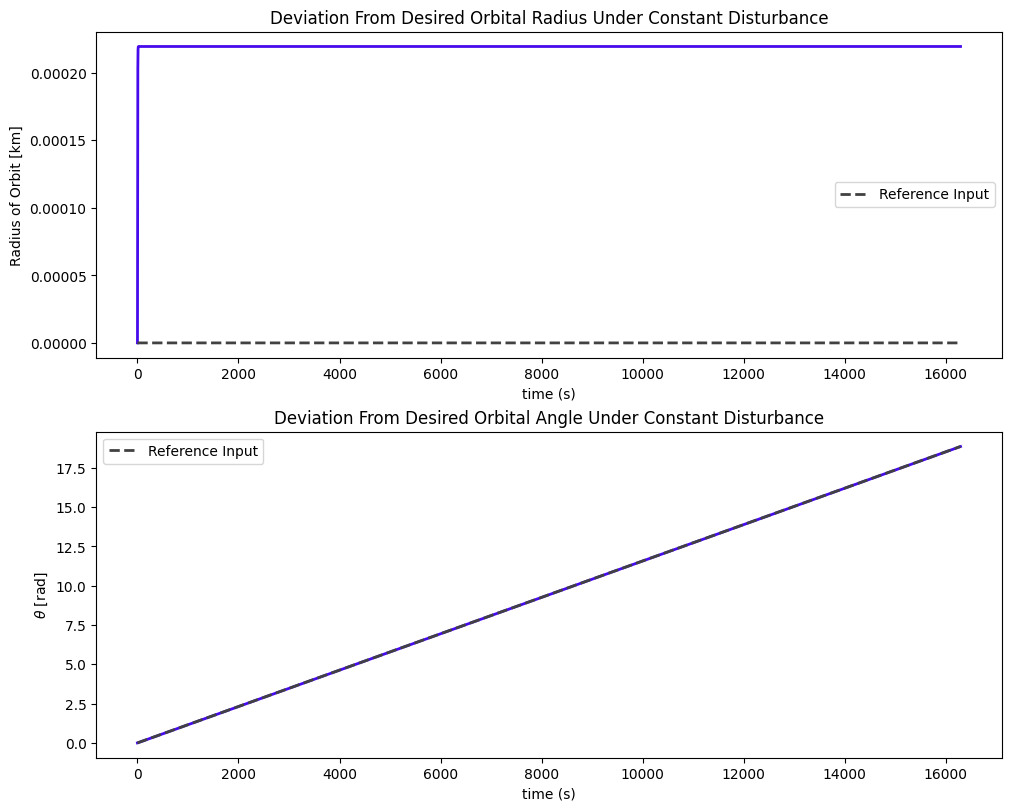

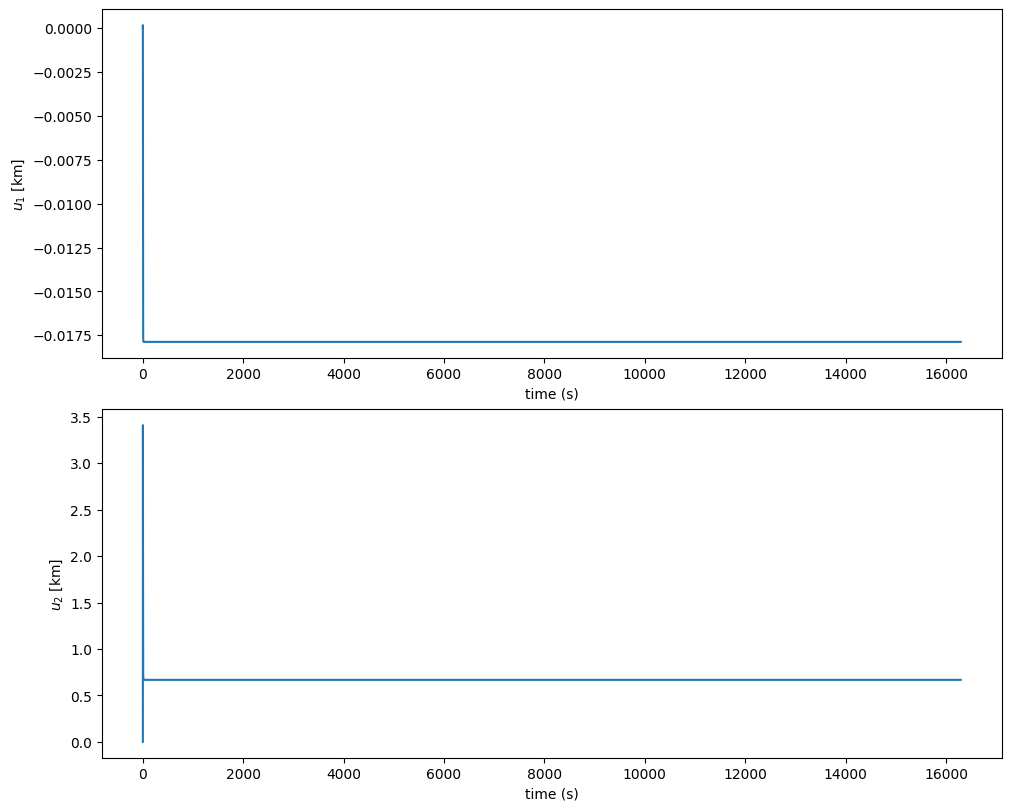

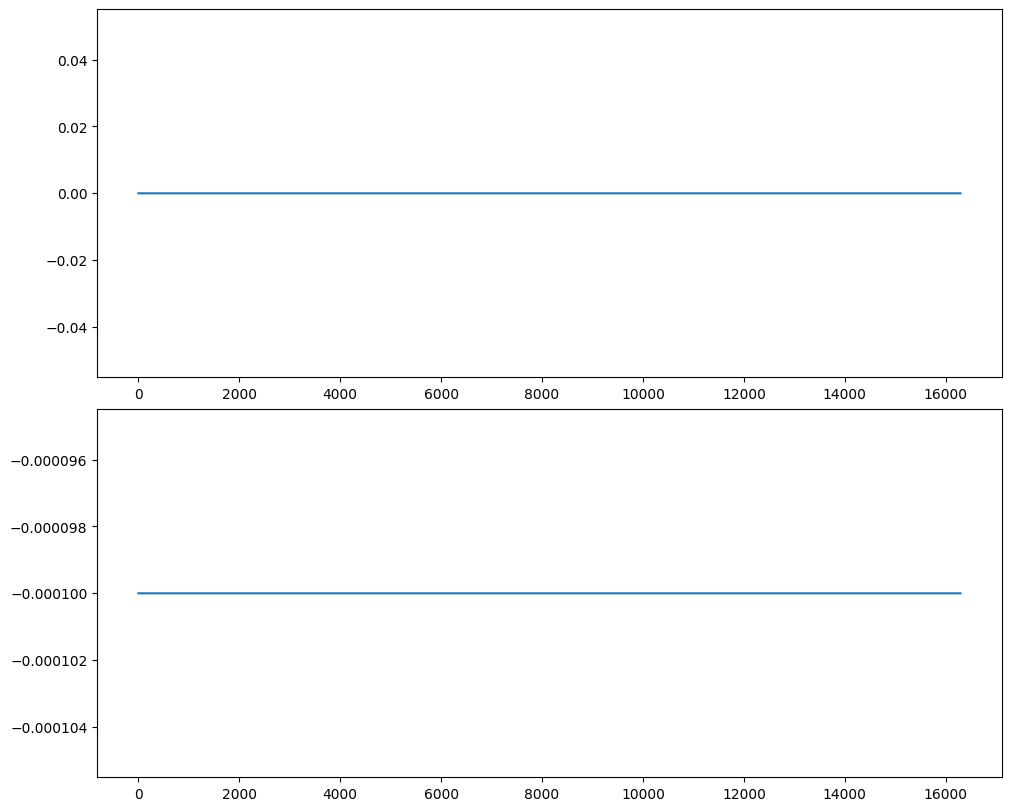

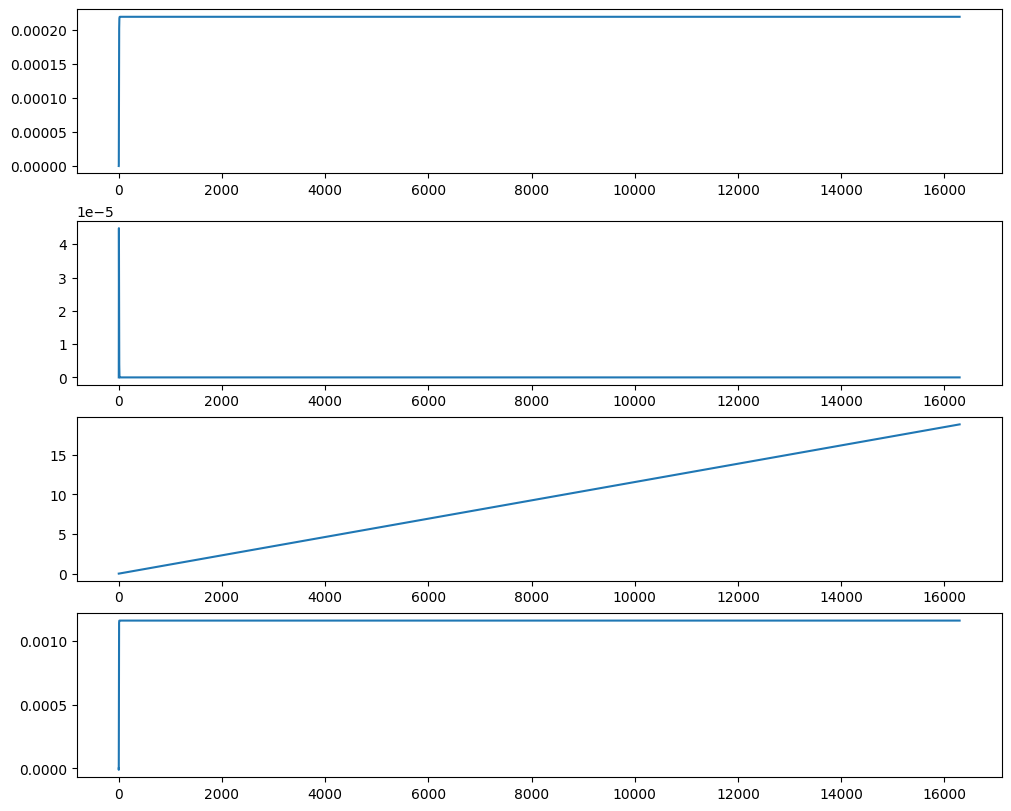

In [14]:
## Integral Controller
# New state: x_aug = [x; x_I]

#Cr = np.array([1,0,0,0]) # C reference, only want to control radius (only reference input)

AaugOL = np.block([[A, np.zeros([4,2])],[-C, np.zeros([2,2])]])
BaugOL = np.block([[B],[np.zeros([2,2])]])
CaugOL = np.block([C, np.zeros([2,2])])
DaugOL = np.zeros([2,4])

# Check reachability of system
P = control.ctrb(AaugOL,BaugOL)

r = np.linalg.matrix_rank(P)
n_states = AaugOL.shape[0]

if n_states == r:
    print("System is reachable \n")

des_poles = np.array([-0.5,-1.1,-1.2,-1.3,-1.4,-1.5])

res = place_poles(AaugOL,BaugOL,des_poles)
Ka = res.gain_matrix

AaugCL = AaugOL - BaugOL@Ka
BaugCL = np.block([[np.zeros([4,2]),G],[np.eye(2),np.zeros([2,2])]])

sys = StateSpace(AaugCL,BaugCL,CaugOL,DaugOL)

ctr = np.block([[ref],[d]])

thist, yhist, xhist = lsim(sys, U = ctr.T, T = tvec)

# Compute resulting control response
U = -Ka@xhist.T

fig, ax = plt.subplots(2,1, figsize=(10, 8), constrained_layout=True)
ax[0].plot(thist,yhist[:,0],color="#460aec",linewidth=2)
ax[0].plot(thist, [0] * len(thist),color="#414141",linewidth=2,linestyle='--',label='Reference Input')
ax[0].set_xlabel("time (s)")
ax[0].set_ylabel('Radius of Orbit [km]')
ax[0].set_title('Deviation From Desired Orbital Radius Under Constant Disturbance')
ax[0].legend()

ax[1].plot(thist,yhist[:,1],color="#460aec",linewidth=2)
ax[1].plot(thist, [omega_des] * thist,color="#414141",linewidth=2,linestyle='--',label='Reference Input')
ax[1].set_xlabel("time (s)")
ax[1].set_ylabel(r'$\theta$ [rad]')
ax[1].set_title('Deviation From Desired Orbital Angle Under Constant Disturbance')
ax[1].legend()

fig, ax = plt.subplots(2,1, figsize=(10, 8), constrained_layout=True)
ax[0].plot(thist,U[0,:])
ax[0].set_xlabel("time (s)")
ax[0].set_ylabel(r'$u_1$ [km]')

ax[1].plot(thist,U[1,:])
ax[1].set_xlabel("time (s)")
ax[1].set_ylabel(r'$u_2$ [km]')

fig, ax = plt.subplots(2,1, figsize=(10, 8), constrained_layout=True)
ax[0].plot(thist,d[0,:])
ax[1].plot(thist,d[1,:])

fig, ax = plt.subplots(4,1, figsize=(10, 8), constrained_layout=True)
ax[0].plot(thist,xhist[:,0])
ax[1].plot(thist,xhist[:,1])
ax[2].plot(thist,xhist[:,2])
ax[3].plot(thist,xhist[:,3])

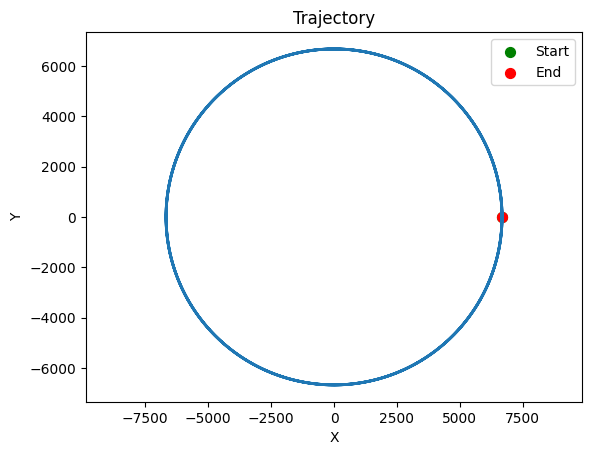

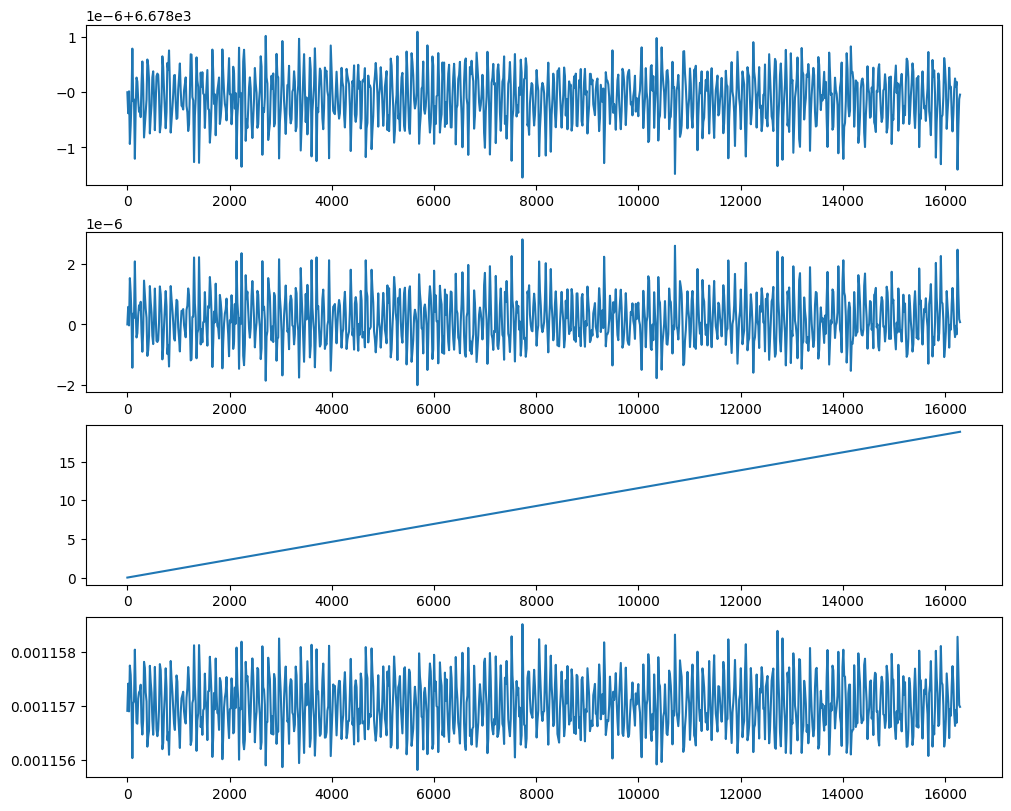

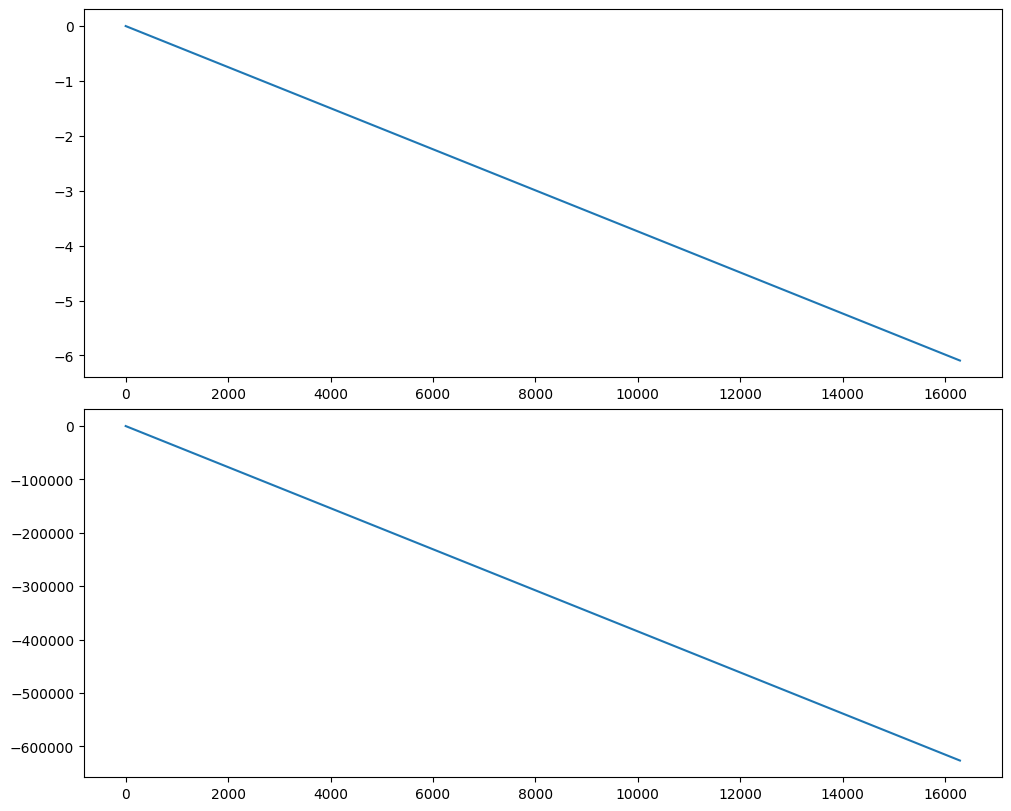

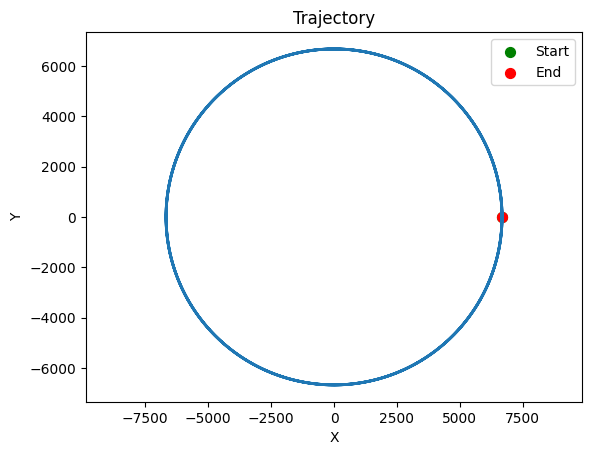

In [15]:
## Use control law with NL dynamics

def contr_func(X, K):
    return -K@X

def sim_func(t,X, U, mu, R = None):
    r = X[0]
    r_dot = X[1]
    theta = X[2]
    theta_dot = X[3]
    

    X_dot = np.zeros(6)

    X_nom = np.array([r0,0,omega_des*t,omega_des,0,0]).T
    
    e = X-X_nom
    Ulin = U(e, R)

    u1 = Ulin[0]
    u2 = Ulin[1]
    #u2 = 0   
    

    X_dot[0] = r_dot
    X_dot[1] = r*theta_dot**2 - mu/(r**2) + u1
    X_dot[2] = theta_dot
    X_dot[3] = -2*theta_dot*r_dot/r + u2/r
    X_dot[4] = -e[0]
    X_dot[5] = -e[2]

    return X_dot

def prop_orbit_controller(X0, tspan, Ufxn,mu, K, num_eval = 1000):
    int_func = lambda t, X: sim_func(t,X, Ufxn, mu, K)
    teval = np.linspace(tspan[0], tspan[1], num_eval)
    sol = sci.integrate.solve_ivp(int_func, tspan, X0, t_eval= teval)

    return [sol.y, sol.t]

X0 = np.array([r0,0,0,omega_des,0,0]).T
tspan = [0, 3*T]

X, t = prop_orbit_controller(X0, tspan, contr_func,mu,Ka)


fig, ax = plt.subplots(4,1, figsize=(10, 8), constrained_layout=True)
ax[0].plot(t,X[0,:])
ax[1].plot(t,X[1,:])
ax[2].plot(t,X[2,:])
ax[3].plot(t,X[3,:])

U = np.zeros([2,len(t)])
X_nom = np.array([r0,0,0,omega_des,0,0]).T

for i in range(len(t)):
    temp =  contr_func(X[:,i]-X_nom,Ka)
    np.reshape(temp,[1,2])
    U[0,i] = temp[0]
    U[1,i] = temp[1]


fig, ax = plt.subplots(2,1, figsize=(10, 8), constrained_layout=True)
ax[0].plot(t,U[0,:])
ax[1].plot(t,U[1,:])

plot_XY(X)
